Задание  
Данные берем отызывы за лето  
На вебинаре мы говорили, что долгое время CNN и RNN архитектуры были конурируещими выяснить какая архитектура больше подходит для нашей задачи  
1. построить свёрточные архитектуры  
2. построить различные архитектуры с RNN  
3. построить совместные архитектуры CNN -> RNN или (RNN -> CNN)  

In [1]:
# попробуем запрограммировать простую рекурентную сеть. Возьмем датасет с прошлого занятия

import pandas as pd
from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re

df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")
df_val = pd.read_csv("data/val.csv")



In [3]:
df_test.head()

,id,text
0,204150,Тектоника и рельеф-самое ужасное в мире мучение(
1,204151,"Ходили запускать шар желаний, но у нас не полу..."
2,204152,"Хочу лето только ради того, что бы направить н..."
3,204153,RT @RonyLiss: @colf_ne блин((\nа я шипперила Ф...
4,204154,"RT @anna_romt: @ZADROT_PO_IGRAM блин,каждое во..."


In [4]:
df_train.head()

,id,text,class
0,0,@alisachachka не уезжаааааааай. :(❤ я тоже не ...,0
1,1,RT @GalyginVadim: Ребята и девчата!\nВсе в кин...,1
2,2,RT @ARTEM_KLYUSHIN: Кто ненавидит пробки ретви...,0
3,3,RT @epupybobv: Хочется котлету по-киевски. Зап...,1
4,4,@KarineKurganova @Yess__Boss босапопа есбоса н...,1


In [5]:
def cobj(df):
        if df == 1:
            return 'positive'
        else:
            return 'negative'

In [6]:
df_train['class_obj'] = df_train['class'].apply(cobj)
df_val['class_obj'] = df_val['class'].apply(cobj)

In [7]:
df_train.shape

(181467, 4)

обработка текста

In [9]:
import re
def funk_del(input_txt):
    pattern = "@[\w]*"
    if re.findall(pattern, input_txt):
        return re.sub(pattern, ' ', input_txt)
    else:
        return re.sub(pattern, ' ', input_txt)


In [10]:
sw = set(get_stop_words("ru"))
exclude = set(punctuation)
morpher = MorphAnalyzer()

def preprocess_text(txt):
    txt = str(txt)
    txt =  re.sub(r'[^а-яА-Я]', ' ', txt) # Заменим спец. символы на пробелы
    txt = funk_del(txt) # Удалим @word из всех твитов
#     txt = "".join(c for c in txt if c not in exclude)
    txt = txt.lower()
    txt = re.sub("\sне", "не", txt)
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    return " ".join(txt)

df_train['text'] = df_train['text'].apply(preprocess_text)
df_val['text'] = df_val['text'].apply(preprocess_text)
df_test['text'] = df_test['text'].apply(preprocess_text)

In [11]:
sentiment_label_train = df_train['class_obj'].factorize()
sentiment_label_val = df_val['class_obj'].factorize()

In [12]:
import numpy as np
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Input, Embedding, Conv1D,GlobalMaxPool1D, SimpleRNN, LSTM, GRU, Masking, MaxPool1D, Normalization
from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import TensorBoard 
# from keras.objectives import categorical_crossentropy
from keras.callbacks import EarlyStopping  

<BarContainer object of 220 artists>

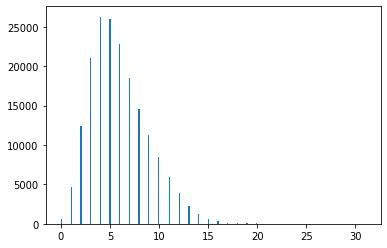

In [67]:
%matplotlib inline
import matplotlib.pyplot as plt

_, _, hist = plt.hist(df_train.text.apply(lambda text: len(text.split())), bins='auto')
hist

In [13]:
word_count = 20000

In [14]:
text_corpus_train = df_train['text'].values
text_corpus_valid = df_val['text'].values
text_corpus_test = df_test['text'].values

In [63]:
print(len(text_corpus_train))
print(len(text_corpus_valid))
print(len(text_corpus_test))

181467
22683
22684


токенизация, выделение в переменную максимальное кол-во токенов, максимальная длина твита

In [15]:
tokenizer = Tokenizer(num_words=word_count, 
                     filters='#$%&()*+-<=>@[\\]^_`{|}~\t\n',
                     lower = False, split = ' ')
tokenizer.fit_on_texts(text_corpus_train)

sequences_train = tokenizer.texts_to_sequences(text_corpus_train)
sequences_val = tokenizer.texts_to_sequences(text_corpus_valid)
sequences_test = tokenizer.texts_to_sequences(text_corpus_test)

word_count = len(tokenizer.index_word) + 1
training_length = max([len(i.split()) for i in text_corpus_train])

X_train = pad_sequences(sequences_train, maxlen=training_length)
X_valid = pad_sequences(sequences_val, maxlen=training_length)
X_test = pad_sequences(sequences_test, maxlen=training_length)



In [16]:
word_count, training_length

(96560, 31)

In [17]:
df_train["class"].unique()

array([0, 1], dtype=int64)

In [22]:
import time
def exec_time(start, end):
    diff_time = end - start
    m, s = divmod(diff_time, 60)
    h, m = divmod(m, 60)
    s,m,h = int(round(s, 0)), int(round(m, 0)), int(round(h, 0))
    return "{0:02d}:{1:02d}:{2:02d}".format(h, m, s)
#    print("Execution Time: " + "{0:02d}:{1:02d}:{2:02d}".format(h, m, s))

## lstm

In [60]:
model_lstm = Sequential()

model_lstm.add(
    Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=X_train.shape[1],
              trainable=True,
              mask_zero=True))
model_lstm.add(Masking(mask_value=0.0))
model_lstm.add(LSTM(64, dropout=0.5, recurrent_dropout=0.5))
model_lstm.add(Normalization(axis=None))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(10, activation='LeakyReLU'))
model_lstm.add(Dense(1, activation='sigmoid'))

model_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 31, 31)            2993360   
                                                                 
 masking_3 (Masking)         (None, 31, 31)            0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                24576     
                                                                 
 normalization_3 (Normalizat  (None, 64)               3         
 ion)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 10)                650       
                                                      

In [61]:
model_lstm.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [98]:
%%time
start = time.time()




early_stopping=EarlyStopping(monitor='val_loss')  


history = model_lstm.fit(X_train, sentiment_label_train[0],
                    batch_size=128,
                    epochs=10,
                    verbose=1,
                    validation_split=0.3,
                    callbacks=[early_stopping])
end = time.time()
time_con = exec_time(start,end)

Epoch 1/10
993/993 [==============================] - 59s 59ms/step - loss: 0.3691 - accuracy: 0.8221 - val_loss: 0.7270 - val_accuracy: 0.7068
Epoch 2/10
993/993 [==============================] - 57s 57ms/step - loss: 0.3582 - accuracy: 0.8271 - val_loss: 0.7741 - val_accuracy: 0.7048
Wall time: 1min 55s


In [88]:
model_lstm.save('lstm')

INFO:tensorflow:Assets written to: lstm\assets


INFO:tensorflow:Assets written to: lstm\assets


In [16]:
reconstructed_model = keras.models.load_model("lstm")

In [90]:
import pickle
# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)



In [91]:
# loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer1 = pickle.load(handle)

In [94]:
import pickle
# saving
with open('sentiment_label_train.pickle', 'wb') as handle:
    pickle.dump(sentiment_label_train, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [95]:
# loading
with open('sentiment_label_train.pickle', 'rb') as handle:
    sentiment_label_train12 = pickle.load(handle)

In [84]:
st_word ="хорошая погода"
print(preprocess_text(st_word))

хороший погода


In [97]:
test_word ="не очень погода"
test_word = preprocess_text(test_word)
tw = tokenizer1.texts_to_sequences([test_word])
print(tw)
tw = pad_sequences(tw,maxlen=31)
print(tw)
prediction = int(model_lstm.predict(tw).round().item())
# prediction = int(np.array([[0.75]]).round().item())
# # print(type(model_lstm.predict(tw)))
# print(prediction)
sentiment_label_train12[1][prediction]

[[259]]
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0 259]]
1/1 [==============================] - 0s 28ms/step


'negative'